<a href="https://colab.research.google.com/github/segreaves/PyTorch-LSTM-TimeSeriesForecasting/blob/main/time_series_forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

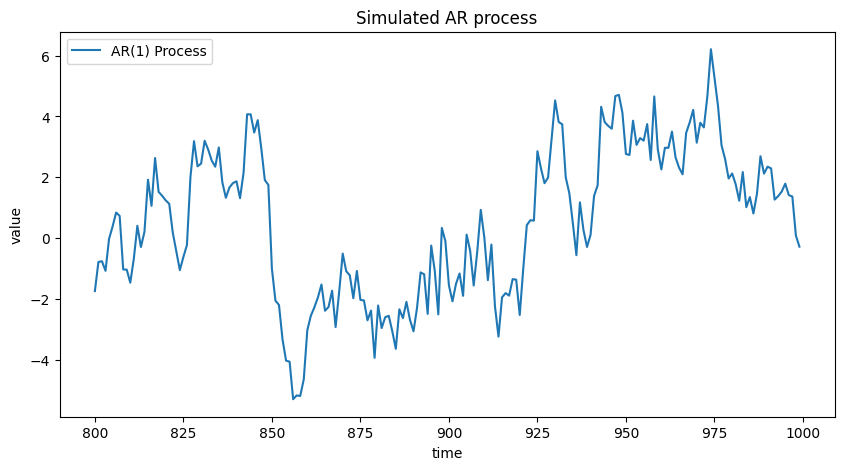

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess

# simpulate time series data
np.random.seed(0)
n_points = 1000
ar_params = np.array([1, -0.9])
ma_params = np.array([1])

# generate AR(1) process
arma_process = ArmaProcess(ar_params, ma_params)
data = arma_process.generate_sample(nsample=n_points)

df = pd.DataFrame({'time': np.arange(n_points), 'value': data})
df__=df[800:]
plt.figure(figsize=(10, 5))
plt.plot(df__['time'], df__['value'], label='AR(1) Process')
plt.xlabel('time')
plt.ylabel('value')
plt.title('Simulated AR process')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
# set up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from copy import deepcopy as dc
def prepare_dataframe_for_lstm(df, n_steps):
  df = dc(df)
  df.set_index('time', inplace = True)
  for i in range(1, n_steps + 1):
    df[f'value(t - {i})'] = df['value'].shift(i)
  df.dropna(inplace = True)
  return df

lookback = 30
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df.head()

,value,value(t - 1),value(t - 2),value(t - 3),value(t - 4),value(t - 5),value(t - 6),value(t - 7),value(t - 8),value(t - 9),...,value(t - 21),value(t - 22),value(t - 23),value(t - 24),value(t - 25),value(t - 26),value(t - 27),value(t - 28),value(t - 29),value(t - 30)
time,,,,,,,,,,,,,,,,,,,,,
30,3.372401,3.574948,2.339543,0.896405,1.203987,1.286921,3.045874,0.862355,1.782800,1.020404,...,3.864013,3.837128,4.378163,5.032800,4.536346,6.126249,4.731879,2.767762,1.987804,1.764052
31,3.413323,3.372401,3.574948,2.339543,0.896405,1.203987,1.286921,3.045874,0.862355,1.782800,...,3.621656,3.864013,3.837128,4.378163,5.032800,4.536346,6.126249,4.731879,2.767762,1.987804
32,2.184205,3.413323,3.372401,3.574948,2.339543,0.896405,1.203987,1.286921,3.045874,0.862355,...,4.713764,3.621656,3.864013,3.837128,4.378163,5.032800,4.536346,6.126249,4.731879,2.767762
33,-0.015012,2.184205,3.413323,3.372401,3.574948,2.339543,0.896405,1.203987,1.286921,3.045874,...,5.003425,4.713764,3.621656,3.864013,3.837128,4.378163,5.032800,4.536346,6.126249,4.731879
34,-0.361423,-0.015012,2.184205,3.413323,3.372401,3.574948,2.339543,0.896405,1.203987,1.286921,...,4.624757,5.003425,4.713764,3.621656,3.864013,3.837128,4.378163,5.032800,4.536346,6.126249


In [ ]:
# convert dataframe to numpy array
shifted_df_as_np = shifted_df.to_numpy()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[ 0.5615298 ,  0.59280992,  0.40202199, ...,  0.47789522,
         0.35664432,  0.32186021],
       [ 0.56784961,  0.5615298 ,  0.59280992, ...,  0.78323356,
         0.47789522,  0.35664432],
       [ 0.3780325 ,  0.56784961,  0.5615298 , ...,  1.        ,
         0.78323356,  0.47789522],
       ...,
       [ 0.25142319,  0.25867217,  0.31693314, ...,  0.70315379,
         0.63838013,  0.58476092],
       [ 0.053123  ,  0.25142319,  0.25867217, ...,  0.53532068,
         0.70315379,  0.63838013],
       [-0.00342235,  0.053123  ,  0.25142319, ...,  0.63717184,
         0.53532068,  0.70315379]])

In [ ]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((970, 30), (970,))

In [ ]:
X = dc(np.flip(X, axis = 1))
X

array([[0.32186021, 0.35664432, 0.47789522, ..., 0.1791529 , 0.40202199,
        0.59280992],
       [0.35664432, 0.47789522, 0.78323356, ..., 0.40202199, 0.59280992,
        0.5615298 ],
       [0.47789522, 0.78323356, 1.        , ..., 0.59280992, 0.5615298 ,
        0.56784961],
       ...,
       [0.58476092, 0.63838013, 0.70315379, ..., 0.27677803, 0.31693314,
        0.25867217],
       [0.63838013, 0.70315379, 0.53532068, ..., 0.31693314, 0.25867217,
        0.25142319],
       [0.70315379, 0.53532068, 0.63717184, ..., 0.25867217, 0.25142319,
        0.053123  ]])

In [ ]:
# split X, y into train-test
split_index = 800

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 30), (170, 30), (800,), (170,))

In [ ]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 30, 1), (170, 30, 1), (800, 1), (170, 1))

In [ ]:
import torch
import torch.nn as nn
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 30, 1]),
 torch.Size([170, 30, 1]),
 torch.Size([800, 1]),
 torch.Size([170, 1]))

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([16, 30, 1]) torch.Size([16, 1])


In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                        batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch + 1}')
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100 == 99: # print every 100 batches
      avg_loss_across_batches = running_loss / 100
      print('Batch {0}, Loss: {1:.7f}'.format(batch_index + 1,
                                              avg_loss_across_batches))
      running_loss = 0.0
  print()

In [ ]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()

In [ ]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  train_one_epoch()
  validate_one_epoch()

Epoch: 1

Val Loss: 0.185
***************************************************

Epoch: 2

Val Loss: 0.153
***************************************************

Epoch: 3

Val Loss: 0.127
***************************************************

Epoch: 4

Val Loss: 0.092
***************************************************

Epoch: 5

Val Loss: 0.060
***************************************************

Epoch: 6

Val Loss: 0.040
***************************************************

Epoch: 7

Val Loss: 0.033
***************************************************

Epoch: 8

Val Loss: 0.029
***************************************************

Epoch: 9

Val Loss: 0.026
***************************************************

Epoch: 10

Val Loss: 0.025
***************************************************

Epoch: 11

Val Loss: 0.025
***************************************************

Epoch: 12

Val Loss: 0.024
***************************************************

Epoch: 13

Val Loss: 0.023
**********************

In [ ]:
# predict training data
with torch.no_grad():
  predicted_train = model(X_train.to(device)).to('cpu').numpy()

In [ ]:
# predict test data
with torch.no_grad():
  predicted_test = model(X_test.to(device)).to('cpu').numpy()

In [ ]:
# scale training predictions
train_predictions = predicted_train.flatten()

dummies = np.zeros((X_train.shape[0], lookback + 1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])

In [ ]:
# scale new y train
dummies = np.zeros((X_train.shape[0], lookback + 1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])

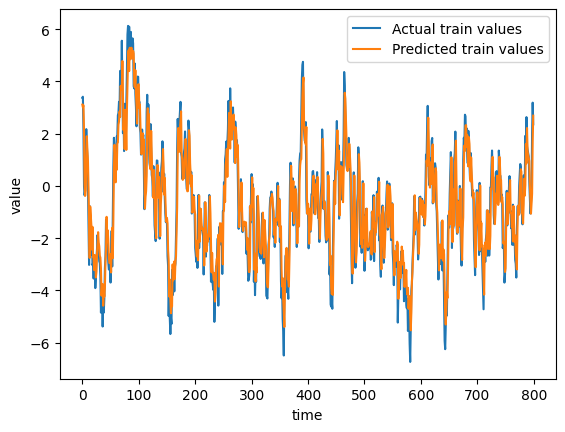

In [ ]:
plt.plot(new_y_train, label = 'Actual train values')
plt.plot(train_predictions, label = 'Predicted train values')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

In [ ]:
# same thing for test data
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback + 1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])

In [ ]:
# scale for y test
dummies =  np.zeros((X_test.shape[0], lookback + 1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

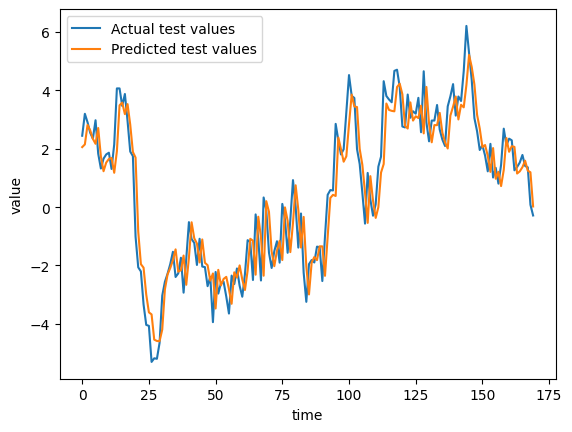

In [ ]:
plt.plot(new_y_test, label='Actual test values')
plt.plot(test_predictions, label = 'Predicted test values')

plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()